In [1]:
import os
import time
import argparse
import torch
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import datasets
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
import numpy as np
import random

BATCH_SIZE = 256
NUM_WORKERS = 0
NUM_EPOCHS = 200
LR = 0.0002
B1 = 0.5
B2 = 0.999
LATENT_DIM = 100
IMG_SIZE = 28
CHANNELS = 1
SAMPLE_INTERVAL = 400

SHUFFLE = True
PIN_MEMORY = True

img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:{}'.format(device))



Device:cuda


In [2]:
# %% train data
#transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])
    ])


train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=0
)

example_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=0,drop_last=True,
    )




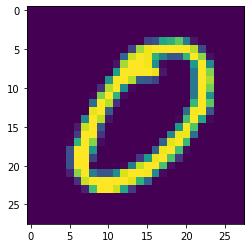

In [31]:
#print some images 
batch = next(iter(example_loader))
_, axarr = plt.subplots(1)
axarr.imshow(batch[0].reshape(-1, 28, 28)[0])

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(LATENT_DIM, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [ ]:
#loss function 
loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    loss.cuda()
    
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(B1 ,B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))
   
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor   


In [ ]:
for epoch in range(NUM_EPOCHS):
    for i, (imgs, _) in enumerate(train_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],LATENT_DIM))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = loss(discriminator(real_imgs), valid)
        fake_loss = loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(train_loader) + i
       
    
    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch,NUM_EPOCHS, i, len(train_loader), d_loss.item(), g_loss.item()))

In [ ]:
#Input image 
z = Variable(Tensor(np.random.normal(0, 1, (256,100)))).cpu()
f, axarr = plt.subplots(1)
axarr.imshow(z)


In [ ]:
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],LATENT_DIM)))).cpu()
rand_latent = torch.rand(imgs.shape[0],LATENT_DIM).cpu()

In [ ]:
generator.to('cpu')
discriminator.to('cpu')

with torch.no_grad():

    f, axarr = plt.subplots(1)
    
    rand_latent = torch.rand(imgs.shape[0],LATENT_DIM).cpu()
    print(rand_latent.shape)
    
    fake_image = generator(rand_latent)
    
    #axarr[1].imshow(z[0].cpu())
   
    fake_image = fake_image[0].reshape(-1, 28, 28)
    axarr.imshow(fake_image[0].cpu())

In [ ]:
generator.to('cpu')
discriminator.to('cpu')
with torch.no_grad():
    for image, _ in example_loader:
        int = 0#random.randint(0, 1)
        f, axarr = plt.subplots(1)
        
       
        
        #z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],LATENT_DIM)))).cpu()
        #fake_image = generator(z)[0]#.detach().numpy()
        
        
        image = image.reshape(-1, 28, 28)
        print(fake_image.shape)
        
        #feed discriminator fake image, expect "0" output
        if int == 0:
            axarr.imshow(fake_image[0])
            pred = discriminator(fake_image)
            print("Discriminator Prediction: {},Should be: {}".format(pred,"0"))
        #feed discriminator real image, expect "1" output
        else:
            axarr.imshow(image[0])
            pred = discriminator(image)
            print("Discriminator Prediction: {},Should be: {}".format(pred,"1"))
        
        
        
        
        
        break

In [ ]:
print(fake_image.device)